In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ChurnApp").getOrCreate()
spark

^C


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Data Loading


In [ ]:
df = pd.read_csv('/content/customer_churn_dataset-training-master.csv')
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [ ]:
df.isnull().sum()

,0
CustomerID,1
Age,1
Gender,1
Tenure,1
Usage Frequency,1
Support Calls,1
Payment Delay,1
Subscription Type,1
Contract Length,1
Total Spend,1


In [ ]:
# هعرض الصفوف التي تحتوي على قيم مفقودة
df[df.isnull().any(axis=1)]

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

,0
CustomerID,0
Age,0
Gender,0
Tenure,0
Usage Frequency,0
Support Calls,0
Payment Delay,0
Subscription Type,0
Contract Length,0
Total Spend,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df['CustomerID'].duplicated().sum()

np.int64(0)

In [ ]:
# Dropped columns
# dropped_cols = ['Gender','Age','CustomerID']

# # Create subplots (adjust nrows/ncols based on len(dropped_cols); here 3x2 for 5 cols)
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
# axes = axes.flatten()  # Flatten for easy indexing

# for i, col in enumerate(dropped_cols):
#     if i < len(axes):  # Safety check
#         # Compute mean churn by category
#         churn_by_cat = df.groupby(col)['Churn'].mean().sort_values(ascending=False)

#         # Bar plot on subplot
#         axes[i].bar(range(len(churn_by_cat)), churn_by_cat.values, color='skyblue')
#         axes[i].set_title(f'Mean Churn Rate by {col}')
#         axes[i].set_xlabel(col)
#         axes[i].set_ylabel('Churn Rate')
#         axes[i].set_xticks(range(len(churn_by_cat)))
#         axes[i].set_xticklabels(churn_by_cat.index, rotation=45, ha='right')

#         # Add value labels on bars
#         for j, v in enumerate(churn_by_cat.values):
#             axes[i].text(j, v + 0.01, f'{v:.2f}', ha='center', va='bottom')

# # Hide empty subplot if odd number
# if len(dropped_cols) < len(axes):
#     axes[-1].set_visible(False)

# plt.tight_layout()
# plt.show()

# # Print summary table for reference
# for col in dropped_cols:
#     churn_summary = df.groupby(col)['Churn'].mean().sort_values(ascending=False).round(3)
#     print(f"\nChurn Rate by {col}:\n{churn_summary}")

In [ ]:
df = df.drop(columns=['CustomerID','Age','Gender'])

In [ ]:
print(df.columns.tolist())

['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction', 'Churn']


Exploratory Data  # تحليل البيانات

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Tenure             440832 non-null  float64
 1   Usage Frequency    440832 non-null  float64
 2   Support Calls      440832 non-null  float64
 3   Payment Delay      440832 non-null  float64
 4   Subscription Type  440832 non-null  object 
 5   Contract Length    440832 non-null  object 
 6   Total Spend        440832 non-null  float64
 7   Last Interaction   440832 non-null  float64
 8   Churn              440832 non-null  float64
dtypes: float64(7), object(2)
memory usage: 33.6+ MB


In [ ]:
df.describe()

,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [ ]:
df['Churn'].value_counts()

,count
Churn,
1.0,249999
0.0,190833


In [ ]:
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
1.0,0.567107
0.0,0.432893


Data Visualization

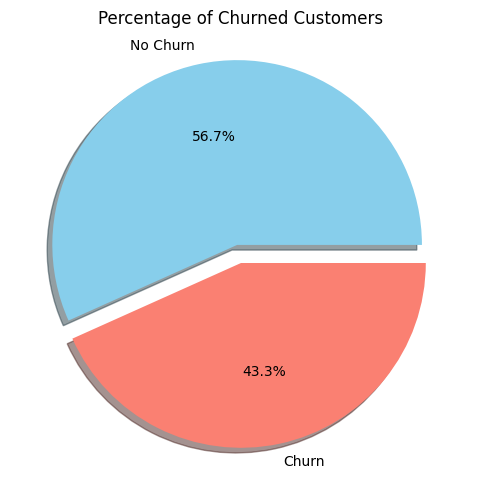

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Percentage of Churned Customers')
plt.pie(
    df['Churn'].value_counts(),
    labels=['No Churn', 'Churn'],
    shadow=True,
    explode=(0.1, 0),
    autopct='%1.1f%%',
    colors=['SkyBlue','Salmon']
)
plt.show()

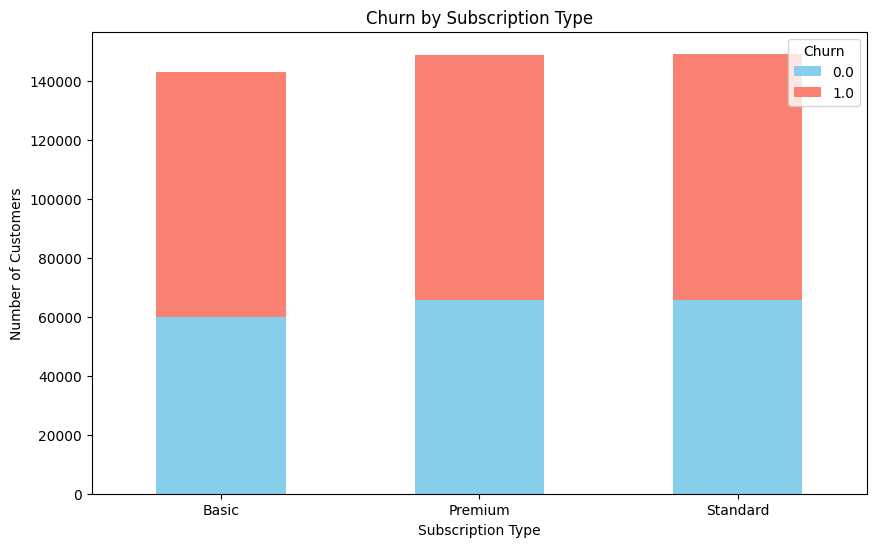

In [ ]:
pd.crosstab(df['Subscription Type'], df['Churn']).plot(
    kind='bar',
    figsize=(10,6),
    stacked=True,
    color=['SkyBlue','Salmon']
    )
plt.title('Churn by Subscription Type')
plt.xlabel('Subscription Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

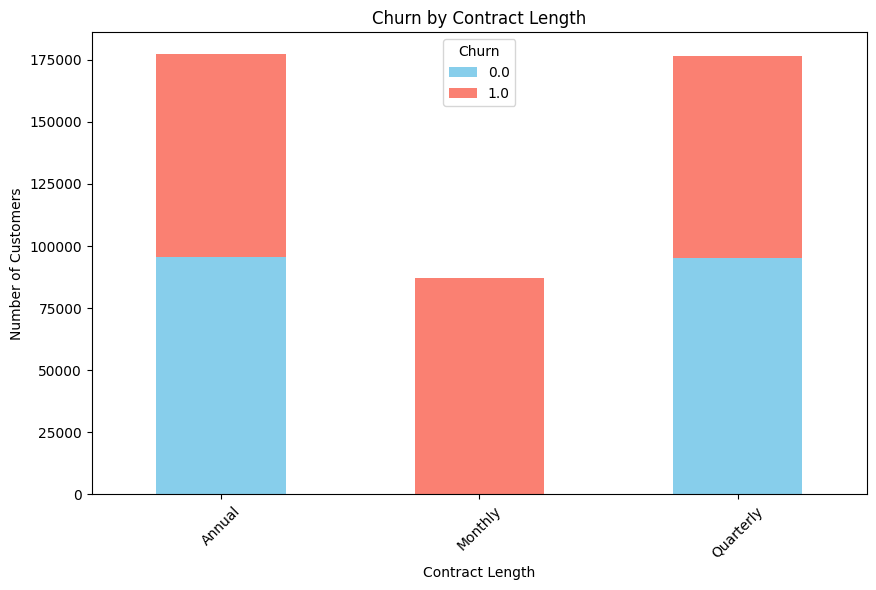

In [ ]:
pd.crosstab(df['Contract Length'], df['Churn']).plot(
    kind='bar',
    figsize=(10,6),
    stacked=True,
    color=['SkyBlue','Salmon']
    )
plt.title('Churn by Contract Length')
plt.xlabel('Contract Length')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

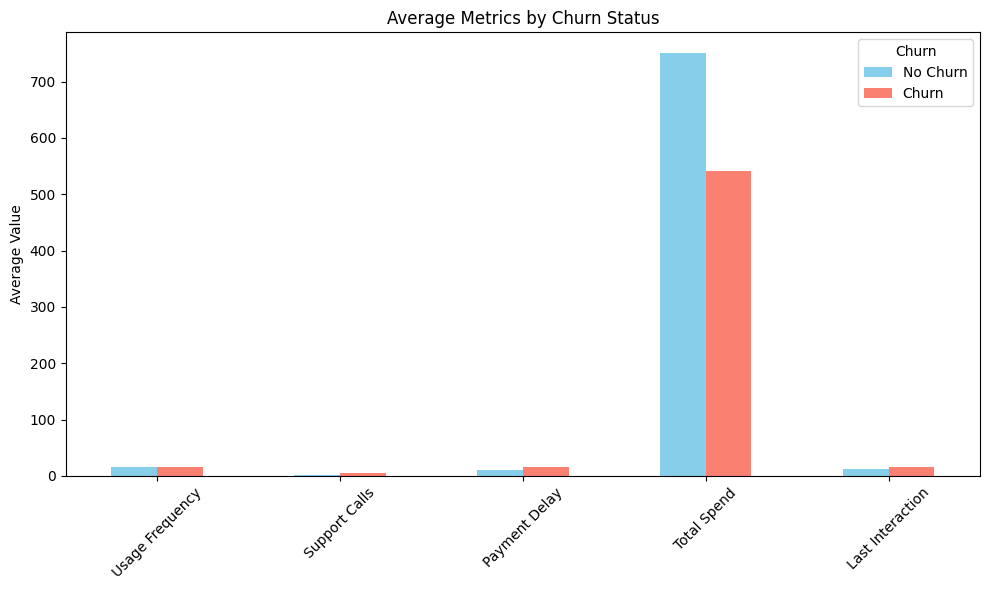

In [ ]:
# cols = ['Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction']
# df.groupby('Churn')[cols].mean().plot(
#     kind='bar',
#     color=['SkyBlue','Salmon'],
#     figsize=(8,6)
# )
# plt.title('Average Metrics by Churn Status')
# plt.ylabel('Average Value')
# plt.xticks(rotation=45)
# plt.show()




cols = ['Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction']

# حساب المتوسط لكل فئة Churn
grouped = df.groupby('Churn')[cols].mean()

# نعمل transpose عشان الميتريك تبقى على المحور x و نعرض شريطين لكل ميتريك
grouped.T.plot(kind='bar', figsize=(10,6), color=['skyblue','salmon'])

plt.title('Average Metrics by Churn Status')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.legend(title='Churn', labels=['No Churn','Churn'])  # لو الـ index هو [0,1]
plt.tight_layout()
plt.show()


/tmp/ipython-input-1251441555.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


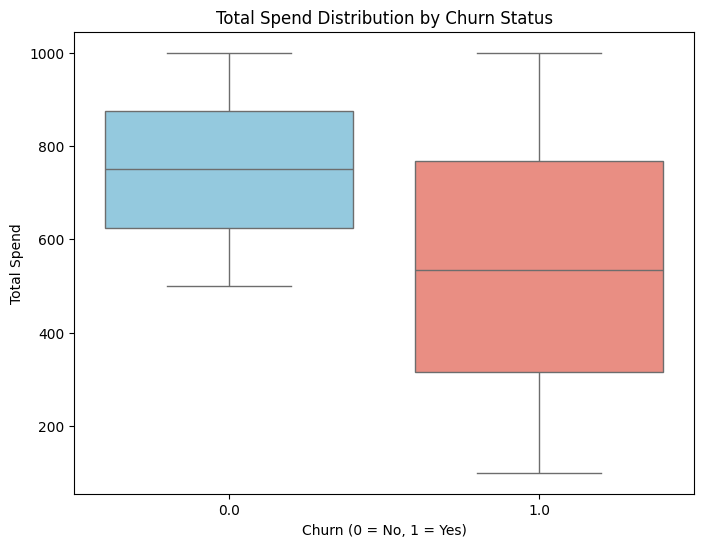

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x='Churn',
    y='Total Spend',
    palette=['SkyBlue','Salmon']
)
plt.title('Total Spend Distribution by Churn Status')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Total Spend')
plt.show()

/tmp/ipython-input-1581530164.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette=['skyblue','salmon'])


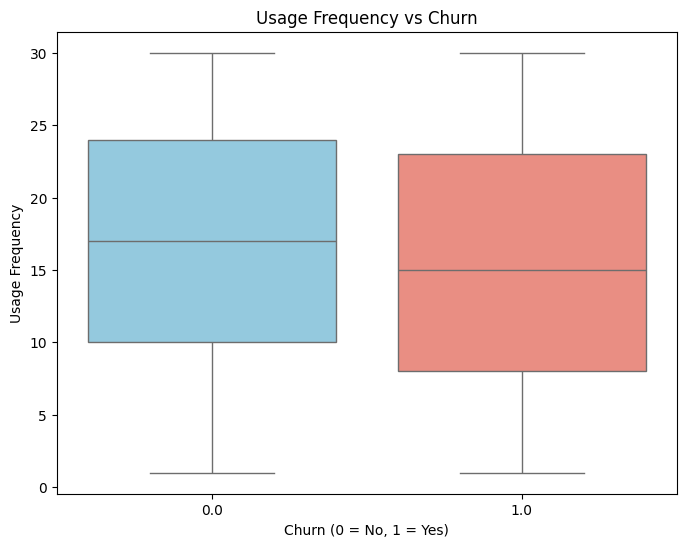

/tmp/ipython-input-1581530164.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette=['skyblue','salmon'])


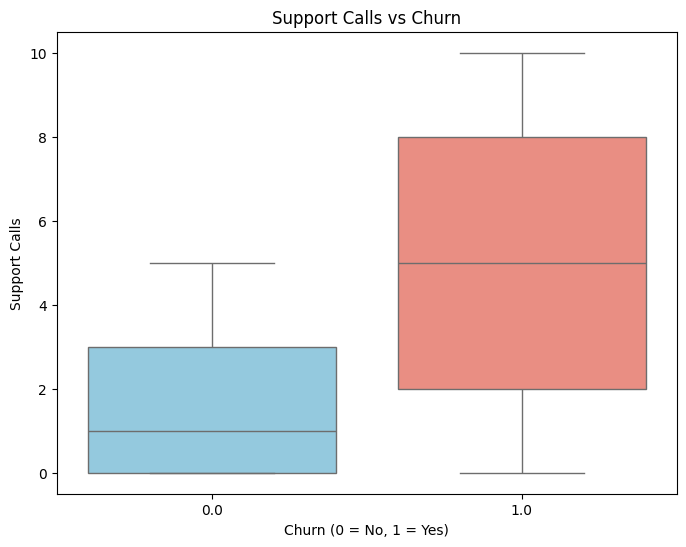

/tmp/ipython-input-1581530164.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette=['skyblue','salmon'])


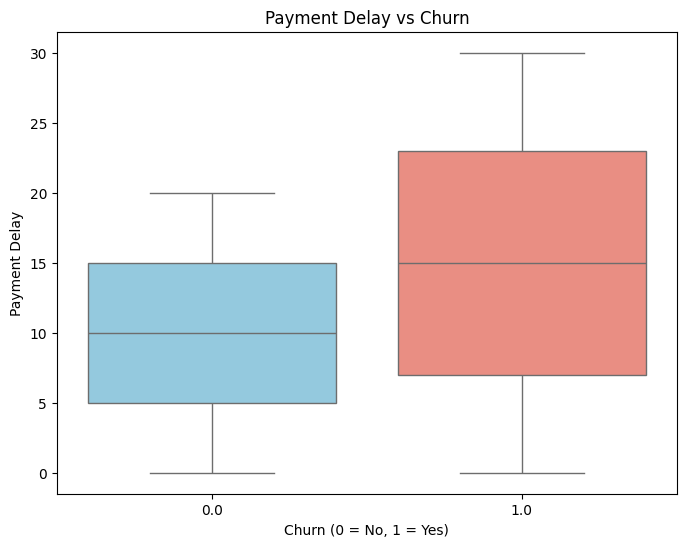

/tmp/ipython-input-1581530164.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette=['skyblue','salmon'])


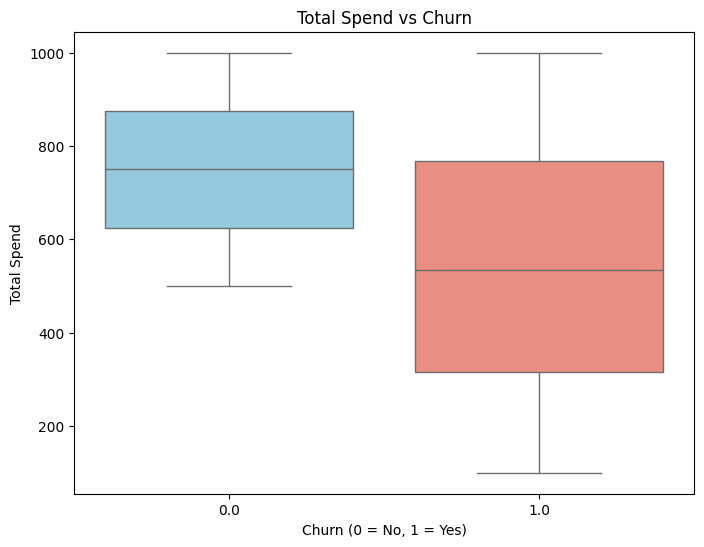

/tmp/ipython-input-1581530164.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette=['skyblue','salmon'])


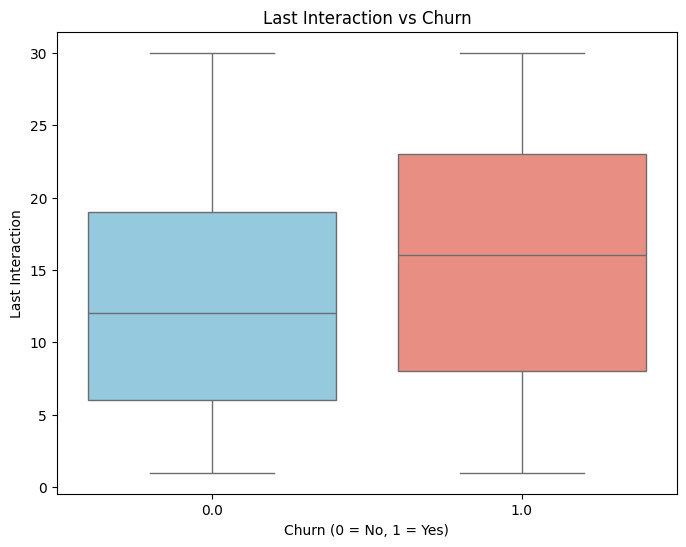

In [ ]:
cols = ['Usage Frequency','Support Calls','Payment Delay','Total Spend','Last Interaction']

for col in cols:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Churn', y=col, data=df, palette=['skyblue','salmon'])
    plt.title(f'{col} vs Churn')
    plt.xlabel('Churn (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.show()

In [ ]:
# نجيب الاعمده الرقميه فقط
numeric_df = df.select_dtypes(include=['float64','int64'])
numeric_df

,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
0,39.0,14.0,5.0,18.0,932.00,17.0,1.0
1,49.0,1.0,10.0,8.0,557.00,6.0,1.0
2,14.0,4.0,6.0,18.0,185.00,3.0,1.0
3,38.0,21.0,7.0,7.0,396.00,29.0,1.0
4,32.0,20.0,5.0,8.0,617.00,20.0,1.0
...,...,...,...,...,...,...,...
440828,54.0,15.0,1.0,3.0,716.38,8.0,0.0
440829,8.0,13.0,1.0,20.0,745.38,2.0,0.0
440830,35.0,27.0,1.0,5.0,977.31,9.0,0.0
440831,55.0,14.0,2.0,0.0,602.55,2.0,0.0


In [ ]:
# نحسب correlation matrix
corr_matrix = numeric_df.corr()
corr_matrix


,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
Tenure,1.000000,-0.026800,-0.027640,-0.016588,0.019006,-0.006903,-0.051919
Usage Frequency,-0.026800,1.000000,-0.022013,-0.014470,0.018631,-0.004662,-0.046101
Support Calls,-0.027640,-0.022013,1.000000,0.162889,-0.221594,0.077684,0.574267
Payment Delay,-0.016588,-0.014470,0.162889,1.000000,-0.121044,0.042708,0.312129
Total Spend,0.019006,0.018631,-0.221594,-0.121044,1.000000,-0.056890,-0.429355
Last Interaction,-0.006903,-0.004662,0.077684,0.042708,-0.056890,1.000000,0.149616
Churn,-0.051919,-0.046101,0.574267,0.312129,-0.429355,0.149616,1.000000


Heatmap

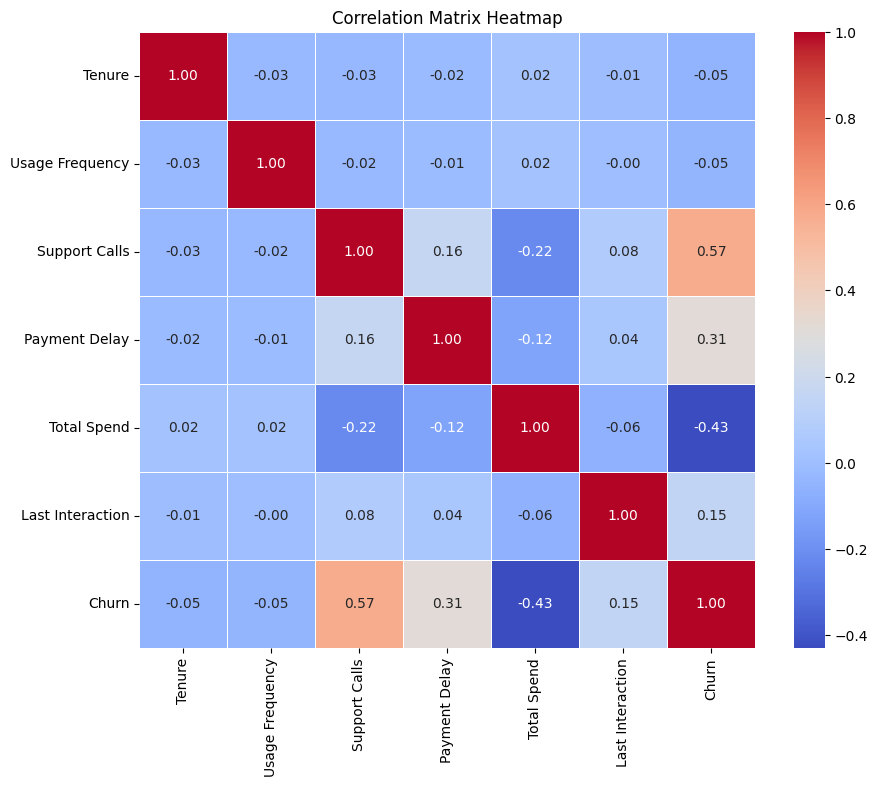

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [ ]:
corr_with_churn = corr_matrix['Churn'].sort_values(ascending=False)
print(corr_with_churn)

Churn               1.000000
Support Calls       0.574267
Payment Delay       0.312129
Last Interaction    0.149616
Usage Frequency    -0.046101
Tenure             -0.051919
Total Spend        -0.429355
Name: Churn, dtype: float64


Spark Part

In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder.appName("Telecom Churn Prediction") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executer.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.extraJavaOptions", "-Djava.net.preferIPv4Stack=true") \
    .getOrCreate()
print("SparkSession created successfully.")
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

SparkSession created successfully.
Spark UI available at: http://8856473b7f7c:4040


In [ ]:
df = spark.read.csv("customer_churn_dataset-training-master.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         2| 30|Female|    39|          

Missing Values

In [ ]:
# null values

from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()



+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         1|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



In [ ]:
df = df.dropna()

Duplicates values

In [ ]:
df = df.dropDuplicates()

Drop rows not import

In [ ]:

# Drop columns not important
df= df.drop('CustomerID', 'Age', 'Gender')

Data Types

In [ ]:
df.printSchema()


root
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)



Using Pipeline


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# ==========================
# 1️⃣ تأكد أن الأعمدة المحولة غير موجودة مسبقًا
cols_to_drop = ['SubscriptionType_index', 'ContractLength_index', 'label', 'features']
for col in cols_to_drop:
    if col in df.columns:
        df = df.drop(col)

# ==========================
# 2️⃣ إنشاء Pipeline
# تحويل الأعمدة النصية وعمود الهدف
indexer1 = StringIndexer(inputCol='Subscription Type', outputCol='SubscriptionType_index')
indexer2 = StringIndexer(inputCol='Contract Length', outputCol='ContractLength_index')
indexer3 = StringIndexer(inputCol='Churn', outputCol='label')

# جمع الأعمدة في features
assembler = VectorAssembler(
    inputCols=['Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
               'Total Spend', 'Last Interaction', 'SubscriptionType_index', 'ContractLength_index'],
    outputCol='features'
)

# تعريف الموديلات
lr = LogisticRegression(featuresCol='features', labelCol='label')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

# إنشاء Pipelines
pipeline_lr = Pipeline(stages=[indexer1, indexer2, indexer3, assembler, lr])
pipeline_dt = Pipeline(stages=[indexer1, indexer2, indexer3, assembler, dt])

# ==========================
# 3️⃣ تقسيم البيانات
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# ==========================
# 4️⃣ تدريب الموديلات
lr_model = pipeline_lr.fit(train_data)
dt_model = pipeline_dt.fit(train_data)

# ==========================
# 5️⃣ التنبؤ على بيانات الاختبار
predictions_lr = lr_model.transform(test_data)
predictions_dt = dt_model.transform(test_data)

# ==========================
# 6️⃣ التقييم
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

for name, preds in [("Logistic Regression", predictions_lr), ("Decision Tree", predictions_dt)]:
    accuracy = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
    precision = evaluator.evaluate(preds, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(preds, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

Logistic Regression - Accuracy: 0.86, Precision: 0.86, Recall: 0.86, F1 Score: 0.86
Decision Tree - Accuracy: 0.95, Precision: 0.96, Recall: 0.95, F1 Score: 0.95


Saving Model

In [ ]:
# ✅ مسارات حفظ الموديلات
lr_path = "/content/lr_model"

[ ]

dt_path = "/content/dt_model"

import os, shutil

# لو المجلدات موجودة مسبقًا نحذفها
for p in [lr_path, dt_path]:
    if os.path.exists(p):
        shutil.rmtree(p)

# ✅ حفظ الموديلات
lr_model.save(lr_path)
dt_model.save(dt_path)

print("✅ Models saved successfully in /content/")

# ✅ ضغط المجلدات لتسهيل التحميل
!zip -r /content/lr_model.zip /content/lr_model
!zip -r /content/dt_model.zip /content/dt_model

# ✅ تحميل الملفات على جهازك
from google.colab import files
files.download("/content/lr_model.zip")
files.download("/content/dt_model.zip")

✅ Models saved successfully in /content/
  adding: content/lr_model/ (stored 0%)
  adding: content/lr_model/stages/ (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/ (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/data/ (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/data/part-00000-28ad7af6-95f3-45e4-93e3-08b698db10fa-c000.snappy.parquet (deflated 68%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/data/._SUCCESS.crc (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/data/_SUCCESS (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/data/.part-00000-28ad7af6-95f3-45e4-93e3-08b698db10fa-c000.snappy.parquet.crc (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/metadata/ (stored 0%)
  adding: content/lr_model/stages/4_LogisticRegression_6188ae63bd59/metadata/part-00000 (deflated 44%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Loading model
**

In [46]:
from pyspark.ml import PipelineModel

# تحميل الـ pipeline كاملة (مش الموديل بس)
lr_loaded = PipelineModel.load("/content/lr_model")
dt_loaded = PipelineModel.load("/content/dt_model")

print("✅ Models loaded successfully!")

✅ Models loaded successfully!


In [1]:
import flask
import pyspark
print("Everything installed and imported successfully!")

Everything installed and imported successfully!
